In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/photo-reconstruction/sample_submission.csv
/kaggle/input/photo-reconstruction/Dataset/Training_Data/Dog/Unmasked_Train/Dog-Train (831).jpeg
/kaggle/input/photo-reconstruction/Dataset/Training_Data/Dog/Masked_Train/Dog-Train (831).jpeg
/kaggle/input/photo-reconstruction/Dataset/Training_Data/Tiger/Unmasked_Train/Tiger (2040).jpeg
/kaggle/input/photo-reconstruction/Dataset/Training_Data/Tiger/Masked_Train/Tiger (2040).jpeg
/kaggle/input/photo-reconstruction/Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (613).jpeg
/kaggle/input/photo-reconstruction/Dataset/Training_Data/Elephant/Masked_Train/Elephant-Train (613).jpeg
/kaggle/input/photo-reconstruction/Dataset/Training_Data/Cat/Unmasked_Train/Cat-Train (1122).jpeg
/kaggle/input/photo-reconstruction/Dataset/Training_Data/Cat/Masked_Train/Cat-Train (1122).jpeg
/kaggle/input/photo-reconstruction/Dataset/Testing_Data/Dog-Train (411).jpeg


# Downloading the model from from gdrive 

In [12]:
!pip install gdown
import gdown

url = "https://drive.google.com/uc?id=1cQt0gGQVnaPOKGkgwxCbLogcJ6lJiIHr"
outputfile = "model7.pth"
gdown.download(url,outputfile,quiet= False)


Downloading...
From: https://drive.google.com/uc?id=1k6pFLBbjFvN2Rahqfep6KbTrzVF-bIEo
To: /kaggle/working/model7.pth
100%|██████████| 3.43M/3.43M [00:00<00:00, 169MB/s]


'model7.pth'

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor, Compose
from torch.utils.data import Dataset


In [14]:
# Creating the BiLSTM Model Class
import torch.nn as nn
class BiLSTM_model(nn.Module):
    def __init__(self, size_in, size_h, layes):
        super(BiLSTM_model, self).__init__()
        self.lstm = nn.LSTM(size_in, size_h, layes, bidirectional=True)
        self.fc = nn.Linear(size_h*2, size_in)

    def forward(self, x):
        output, dummy = self.lstm(x)
        output = self.fc(output)
        return output

In [17]:
output_path ="/kaggle/working"
# model = BiLSTM_model(size_in=256, size_h=128, layes=2)
# model.load_state_dict(torch.load(f"{output_path}/model7.pth"))
# model.eval()
model = torch.load("/kaggle/working/model7.pth")


In [18]:
def submission_data(test_path):
    test_mask_data = pd.read_csv(test_path + 'masked_info.csv').drop(['Unnamed: 0'],axis=1)
    submission = []

    for i in range(len(test_mask_data)):
        filename, y1, x1, y2, x2 = test_mask_data.loc[i,]
        print(i+1)
        masked_image = Image.open(test_path + filename).convert('RGB')
        masked_tensor = Compose([ToTensor()])(masked_image)
        with torch.no_grad():
            output = model(masked_tensor)
            
        for i in range(y1 , y1+75):
            for j in range(x1, x1+75):
                temp1 = filename + '_' + 'box1' + '_' +  str(i) + '_' + str(j) + '_'
                submission.append((temp1 + '0', output[2][i][j].item()))#B of output and 2 of RGB
                submission.append((temp1 + '1', output[1][i][j].item()))#G of output and 1 of RGB
                submission.append((temp1 + '2', output[0][i][j].item()))#R of output and 0 of RGB

        for i in range(y2 , y2+75):
            for j in range(x2, x2+75):
                temp1 = filename + '_' + 'box2' + '_' + str(i) + '_' + str(j) + '_'
                submission.append((temp1 + '0', output[2][i][j].item()))#B of output and 2 of RGB
                submission.append((temp1 + '1', output[1][i][j].item()))#G of output and 1 of RGB
                submission.append((temp1 + '2', output[0][i][j].item()))#R of output and 0 of RGB
    df = pd.DataFrame(submission, columns=['filename_box_pixel','value'])
    return df;


In [19]:
test_path = "/kaggle/input/photo-reconstruction/Dataset/Testing_Data/"
df = submission_data(test_path)
output_path = '/kaggle/working/'
df.to_csv(f"{output_path}/submission.csv", index = False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


In [33]:
from torchvision.transforms import ToTensor, Compose
from PIL import Image
img_path ="/kaggle/input/photo-reconstruction/Dataset/Training_Data/Cat/Masked_Train/Cat-Train (1007).jpeg"
image = Image.open(img_path)
out_img = model(Compose([ToTensor()])(image))

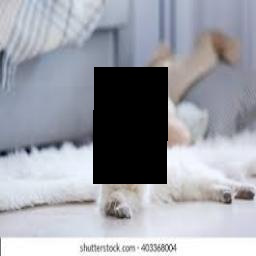

In [34]:
image

In [35]:
from torchvision import transforms as T

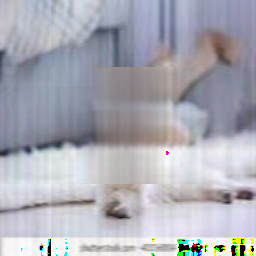

In [36]:
# note that surrounding damaged just while showing the image as reconstruction through pil but while prediction we keep only masks 
T.ToPILImage()(out_img)